In [28]:
# Import necessary modules,
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score,recall_score
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import validation_curve

# Prepare data

In [2]:
monk1_train = pd.read_csv('data/monks-1.train',header=None,sep=" ")
monk1_test = pd.read_csv('data/monks-1.test',header=None,sep=" ")

In [3]:
monk1_train.drop(0,axis=1,inplace=True)
monk1_train.drop(8,axis=1,inplace=True)

monk1_test.drop(0,axis=1,inplace=True)
monk1_test.drop(8,axis=1,inplace=True)

In [5]:
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a4', 'a6']
monk1_train.columns = columns
monk1_test.columns = columns

In [6]:
ytr = monk1_train.iloc[:,0]
xtr = monk1_train.iloc[:,1:]


xts = monk1_test.iloc[:,1:]
yts = monk1_test.iloc[:,0]

# 1Hot encoding

In [7]:
encoder = OneHotEncoder()
        
encoder.fit(xtr)
xtr = encoder.transform(xtr).toarray()
        
encoder.fit(xts)
xts = encoder.transform(xts).toarray()

In [10]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(xtr,ytr)

SGDClassifier(random_state=42)

# Cross validation

In [12]:
cross_val_score(sgd_clf,xtr,ytr,cv=3,scoring="accuracy")

array([0.71428571, 0.73170732, 0.3902439 ])

# Confusion matrix

In [15]:
y_pred = cross_val_predict(sgd_clf,xtr,ytr,cv=3)
confusion_matrix(ytr,y_pred)

array([[46, 16],
       [32, 30]])

# Precision and Recall tradeoff

# Which threshold use ?

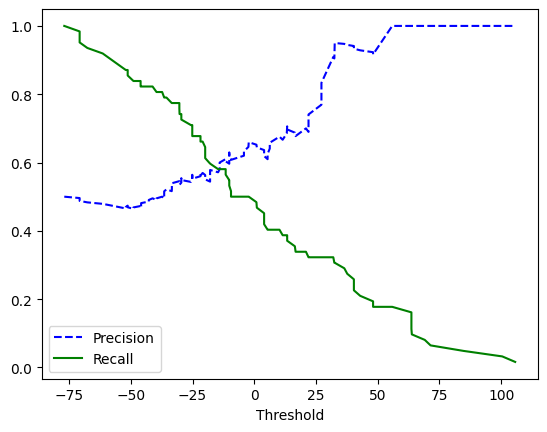

In [25]:
y_scores = cross_val_predict(sgd_clf,xtr,ytr,cv=3,method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(ytr,y_scores)

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend()
    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

# Setting precision to min 90%

In [31]:
threshold_90_pred = thresholds[np.argmax(precisions >= 0.90)]

#make prediction (like .predict())
y_pred_90 = (y_scores >= threshold_90_pred)
# metrics
print(precision_score(ytr,y_pred_90))
print(recall_score(ytr,y_pred_90))

0.9090909090909091
0.3225806451612903


# ROC Curve

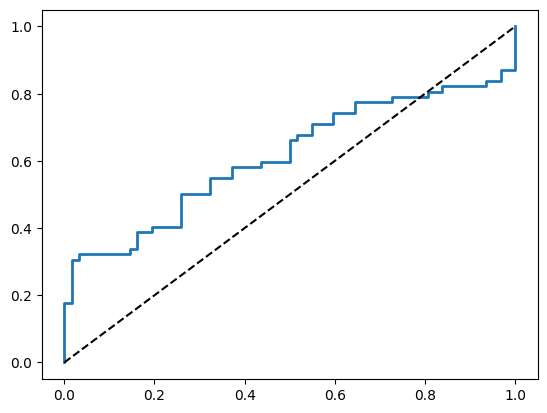

In [34]:
fpr, tpr, thresholds = roc_curve(ytr,y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--') # dashed diagonal
plot_roc_curve(fpr,tpr)
plt.show()

# Area under curve

In [35]:
roc_auc_score(ytr,y_scores)

0.6126430801248699

# RandomForestClassifier

In [36]:
forest_clf = RandomForestClassifier(random_state=42)
# instead of scores, it gives probabilities
y_probas_forest = cross_val_predict(forest_clf,xtr,ytr,cv=3,method="predict_proba")

In [38]:
#scores: prob of positive class
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(ytr,y_scores_forest)

# Comparing SGD and RandomForest

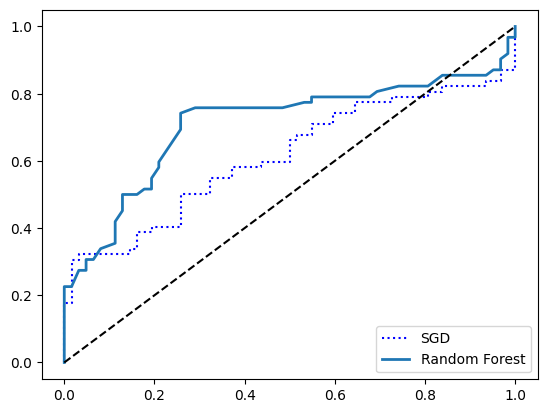

In [39]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [40]:
roc_auc_score(ytr,y_scores_forest)

0.7092872008324662

# 5NN

In [45]:
knn = KNeighborsClassifier() # k=5 default
y_scores_knn = cross_val_predict(knn,xtr,ytr,cv=3)

In [46]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(ytr,y_scores_knn)

# Confronting KNN with RF and SGD

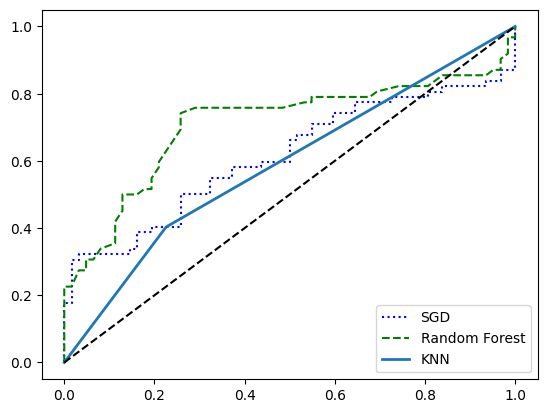

In [60]:
plt.plot(fpr,tpr,"b:",label="SGD")
plt.plot(fpr_forest,tpr_forest,"g--",label="Random Forest")
plot_roc_curve(fpr_knn,tpr_knn,"KNN")
plt.legend(loc="lower right")
plt.show()

In [61]:
roc_auc_score(ytr,y_scores_knn)

0.5887096774193549

# SDG GridSearchCV

# First see the validation curve to choose rigth penalty term

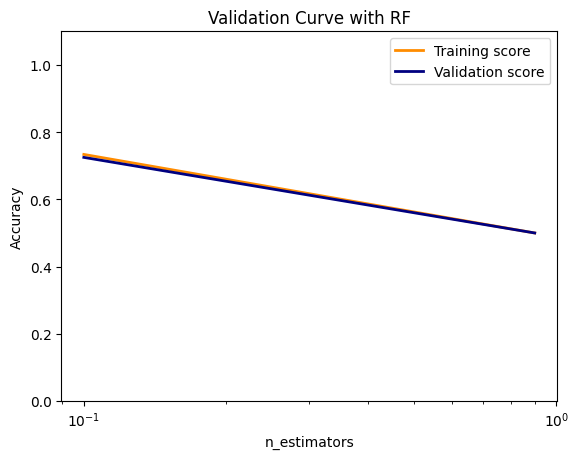

In [144]:
param_range = [0.1,0.9]
train_scores, validation_scores = validation_curve(SGDClassifier(penalty='l1'), xtr, ytr, param_name="alpha", cv=5, param_range=param_range,scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)


plt.title("Validation Curve with RF")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="white",
    lw=lw,
)
plt.semilogx(
    param_range, validation_scores_mean, label="Validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    validation_scores_mean - validation_scores_std,
    validation_scores_mean + validation_scores_std,
    alpha=0.2,
    color="white",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

# Best is 0.1 , hence search and see
# Of course, the higher the term is --> possible underfitting
# because is too regularized

In [126]:
param_grid = [
    {'alpha' : [0.0001,0.0005,0.001,0.01,0.1], 'shuffle' : [True], 'random_state' : [42],
     'penalty': ['l2', 'l1', 'elasticnet'], 'max_iter':[200,300,500,1000],
     'tol':[3,5,10,20,30], 'early_stopping':[True,False],
    }
]

In [127]:
sgd_grid = SGDClassifier()

grid_search = GridSearchCV(sgd_grid,param_grid,cv=5,scoring="accuracy",return_train_score=True)

grid_search.fit(xtr,ytr)

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid=[{'alpha': [0.0001, 0.0005, 0.001, 0.01, 0.1],
                          'early_stopping': [True, False],
                          'max_iter': [200, 300, 500, 1000],
                          'penalty': ['l2', 'l1', 'elasticnet'],
                          'random_state': [42], 'shuffle': [True],
                          'tol': [3, 5, 10, 20, 30]}],
             return_train_score=True, scoring='accuracy')

In [128]:
final_SGD_model = grid_search.best_estimator_
final_SGD_model

SGDClassifier(alpha=0.1, max_iter=200, penalty='l1', random_state=42, tol=3)

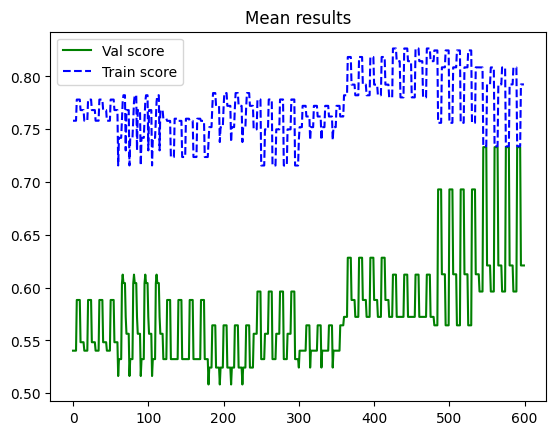

In [129]:
results = grid_search.cv_results_
plt.plot(results['mean_test_score'],"g",label="Val score")
plt.plot(results['mean_train_score'],"b--",label="Train score")
plt.legend()
plt.title("Mean results")
plt.show()

# ROC curve of best_estimator

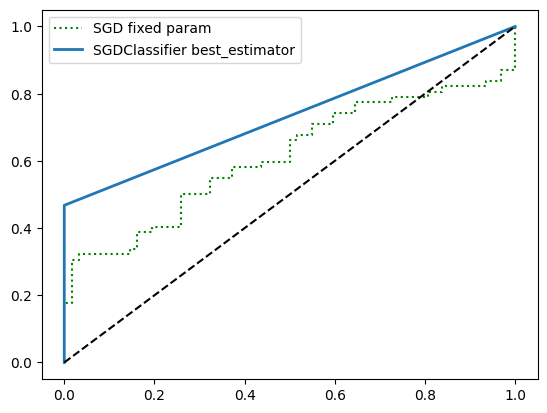

In [131]:
y_scores_sgd_final = cross_val_predict(final_SGD_model,xtr,ytr,cv=3)
fpr_sgd_final, tpr_sgd_final, thresholds_sgd_final = roc_curve(ytr,y_scores_sgd_final)

plt.plot(fpr,tpr,"g:",label="SGD fixed param")
plot_roc_curve(fpr_sgd_final,tpr_sgd_final,"SGDClassifier best_estimator")
plt.legend()

In [132]:
roc_auc_score(ytr,y_scores_sgd_final) #better than the initial one 

0.7338709677419355

# Learning curve

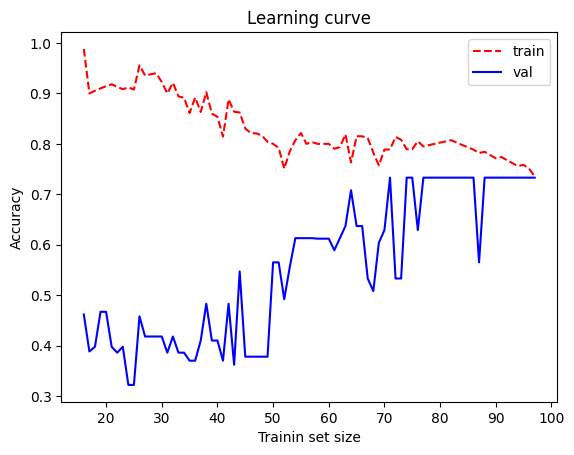

In [133]:
train_sizes, train_scores, test_scores = learning_curve(final_SGD_model, xtr, ytr, cv=5, scoring='accuracy', n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 98))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_mean,"r--",label="train")
plt.plot(test_mean,"b-",label="val")
plt.title("Learning curve")
plt.xlabel("Trainin set size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Test the final SGDClassifier

In [134]:
final_predictions = final_SGD_model.predict(xts)

accuracy_score(yts, final_predictions)

0.75

# RandomForest GridSearchCV

# First, validation curve on n_estimators

In [ ]:
param_grid = [
    {'n_estimators' : [3,5,10,20,30,40,50,60,70,100], 'criterion' : []
    }
]